<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy import misc
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

In [3]:
def poisson(x, mean):
    return np.exp(-mean)*(mean**x)/sp.special.factorial(x)

In [4]:
def skew_norm(x, amplitude, x_offset, sigma_scale, skew_scale):
    return amplitude*skewnorm.pdf(x, skew_scale, scale=sigma_scale, loc=x_offset)

In [5]:
def create_data_array(times, freqs):
    data = []
    for (time, freq) in zip(times, freqs):
        data.extend([time]*int(freq))
    return np.array(data)

We use a modified $\chi^2$ test where

$$\chi^2 = \sum \frac{(E-O)^2}{O} $$

If $O=0$, we replace the denominator with 1. This helps avoid pitfalls where we have large time intervals (but the theoretical models don't predict so).

In [6]:
def compute_chi2_pois(m, times_act, freq_act, num_events):
    
    tot = 0
    for time, freq in zip(times_act, freq_act):
        theo = num_events*poisson(time, m) 
        if freq !=0:
            tot += ((freq-theo)**2)/(freq)
        else:
            tot += ((freq-theo)**2)
            
        
    return tot

def compute_chi2(freq_act, freq_theo):
    
    tot = 0
    for act, theo in zip(freq_act, freq_theo):
        
        if act != 0:
            tot += ((act-theo)**2)/(act)
        else:
            tot += ((act-theo)**2) #Divide by 1
        
    return tot

# Open Data

## Open up Text Files

In [7]:
df1 = pd.read_csv('timing_data/div1_raw.log', skiprows=0, sep='\s+',
                 usecols=[0], names=['Div1'], thousands=',')
df2 = pd.read_csv('timing_data/div2_raw.log', skiprows=0, sep='\s+',
                 usecols=[0], names=['Div2_raw'], thousands=',')
df3 = pd.read_csv('timing_data/div4_raw.log', skiprows=0, sep='\s+',
                 usecols=[0], names=['Div4_raw'], thousands=',')

df = pd.concat([df1, df2, df3], sort=False, axis=1)
df = df.apply(lambda x: x.str.replace(',','').apply(pd.to_numeric))
df.head()

,Div1,Div2_raw,Div4_raw
0,0.105240,0.178124,0.132032
1,0.034400,0.063030,0.106024
2,0.028126,0.105796,0.061340
3,0.060934,0.062289,0.039786
4,0.217106,0.100855,0.051929


## Get Divide by 2 Data

In [8]:
Div2 = np.array([])
for i in range(int(len(df['Div2_raw'])/2)):
    Div2 = np.append(Div2, df['Div2_raw'][2*i+1]+df['Div2_raw'][2*i])

Div2_df = pd.DataFrame({'Div2':Div2})
df = pd.concat([df,Div2_df], axis=1)

## Get Divide by 4 Data

In [9]:
Div4 = np.array([])
for i in range(int(len(df['Div4_raw'])/4)):
    Div4 = np.append(Div4, df['Div4_raw'][4*i+3]+df['Div4_raw'][4*i+2]+df['Div4_raw'][4*i+1]+df['Div4_raw'][4*i])

Div4_df = pd.DataFrame({'Div4':Div4})
df = pd.concat([df,Div4_df], axis=1)

In [10]:
df = df.drop(['Div2_raw', 'Div4_raw'], axis=1)

# Plotting

## Divide by 1

In [11]:
data = df['Div1'].dropna()
num_events = len(data)
bins = 50

Compute the frequencies and bins corresponding to Time between events (s). The array of bins contains numerical values that correspond to the average between the bin edges.

In [12]:
freq_act, _ = np.histogram(data, bins=bins)
times_act = np.array([(_[i+1]+_[i])/2 for i in range(len(_)-1)])

### Poisson Fitting

Convert the times between events to integer values, corresponding to the discrete notion of "counts" for the poisson distribution. We normalize the array so that the first value corresponds to zero; we do this for the data $t$ and the bins $b$ respectively:

$$\vec{t}_{int} = \frac{\vec{t}-\vec{t}_0}{(\vec{t}-\vec{t}_0)_1} \hspace{20mm} \vec{b}_{int} = \frac{\vec{b}-\vec{b}_0}{(\vec{b}-\vec{b}_0)_1}$$

(Note that $\vec{t}_0$ contains all values of $t_0$). $t_{int}$ is now an array of integers and can be treated like the discrete "counts" for the poisson distribution.

In [13]:
data_int = (data-times_act[0])/(times_act-times_act[0])[1]
times_act_int = (times_act-times_act[0])/(times_act-times_act[0])[1]

freq_theo_pois = (num_events)*poisson(times_act_int, np.mean(data_int)) 

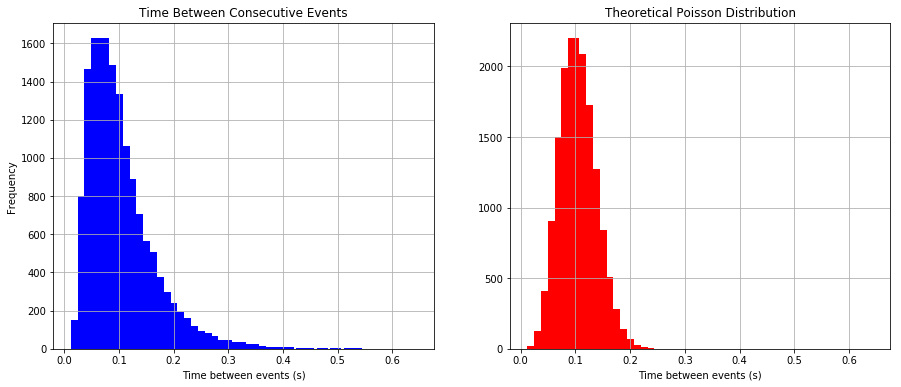

In [14]:
fig, ax = plt.subplots(1,2, figsize=(15,6))


ax[0].bar(times_act, freq_act, width=1/bins, color='b')
ax[1].bar(times_act, freq_theo_pois, width=1/bins, color='r')

ax[0].set_xlabel('Time between events (s)')
ax[1].set_xlabel('Time between events (s)')
ax[0].set_ylabel('Frequency')

ax[0].set_title('Time Between Consecutive Events')
ax[1].set_title('Theoretical Poisson Distribution')

ax[0].grid()
ax[1].grid()

plt.show()

In [15]:
num_bins = len(times_act)
DOF = num_bins - 2

We need to convert $m$ into an array of integers when we use the $\chi^2$ test.

In [16]:
m=np.linspace(0.05, 0.125, 100)
m_int = (m-times_act[0])/(times_act-times_act[0])[1]
chi_test = compute_chi2_pois(m_int, times_act_int, freq_act, num_events)

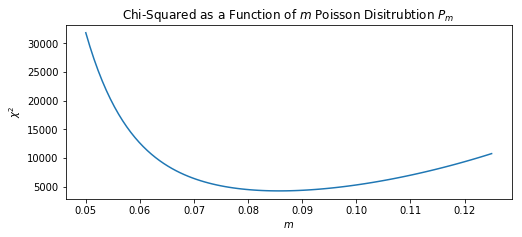

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,3.2))

ax.plot(m, chi_test)
ax.set_title('Chi-Squared as a Function of $m$ Poisson Disitrubtion $P_m$')
ax.set_xlabel('$m$')
ax.set_ylabel('$\chi^2$')

plt.show()

Print the value of $m$ (the theoretical mean) that minimizes the $\chi^2$ value.

In [18]:
print(m[chi_test.argmin()])

0.0856060606060606


Print the $\chi^2$ value.

In [19]:
print(np.min(chi_test))

4239.224704597959


### Skew-Norm Fitting

Use a least squares fitting method (equivalent to minimizing chi-square)

In [20]:
popt, pcov = curve_fit(skew_norm, times_act, freq_act, absolute_sigma=True)
freq_theo_skew = skew_norm(times_act, popt[0], popt[1], popt[2], popt[3])

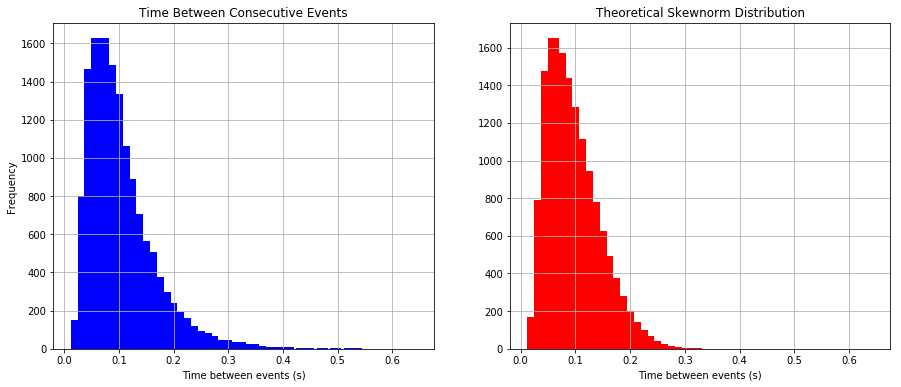

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].bar(times_act, freq_act, width=1/bins, color='b')
ax[1].bar(times_act, freq_theo_skew, width=1/bins, color='r')

ax[0].set_xlabel('Time between events (s)')
ax[1].set_xlabel('Time between events (s)')
ax[0].set_ylabel('Frequency')

ax[0].set_title('Time Between Consecutive Events')
ax[1].set_title('Theoretical Skewnorm Distribution')

ax[0].grid()
ax[1].grid()

plt.show()

Print the value of $\chi^2$.

In [22]:
chi = compute_chi2(freq_act, freq_theo_skew)
print(chi)

445.60756865951817


### Statistics

Print the ratios of the moments

In [23]:
data_raw = create_data_array(times_act, freq_act)
data_pois = create_data_array(times_act, freq_theo_pois)
data_skew = create_data_array(times_act, freq_theo_skew)

In [24]:
scale = 1000
print('Poisson Mean '+str(np.average(data_pois)*scale))
print('Skewnorm Mean '+str(np.average(data_skew)*scale))
print('Actual Mean '+str(np.average(data_raw)*scale))
print('')
print('Poisson Std '+str(np.std(data_pois)*scale))
print('Skewnorm Std '+str(np.std(data_skew)*scale))
print('Actual Std '+str(np.std(data_raw)*scale))
print('')
print('Poisson 3mom '+str(sp.stats.moment(data_pois, 3)*scale))
print('Skewnorm 3mom '+str(sp.stats.moment(data_skew, 3)*scale))
print('Actual 3mom '+str(sp.stats.moment(data_raw, 3)*scale))

Poisson Mean 104.83871798926508
Skewnorm Mean 97.08192040251272
Actual Mean 104.88119203632947

Poisson Std 32.08959278527093
Skewnorm Std 47.23839499842466
Actual Std 61.28383498767267

Poisson 3mom 0.012392370810362164
Skewnorm 3mom 0.09561338244319119
Actual 3mom 0.4011091759014677


### Nice Plot for Lab Report

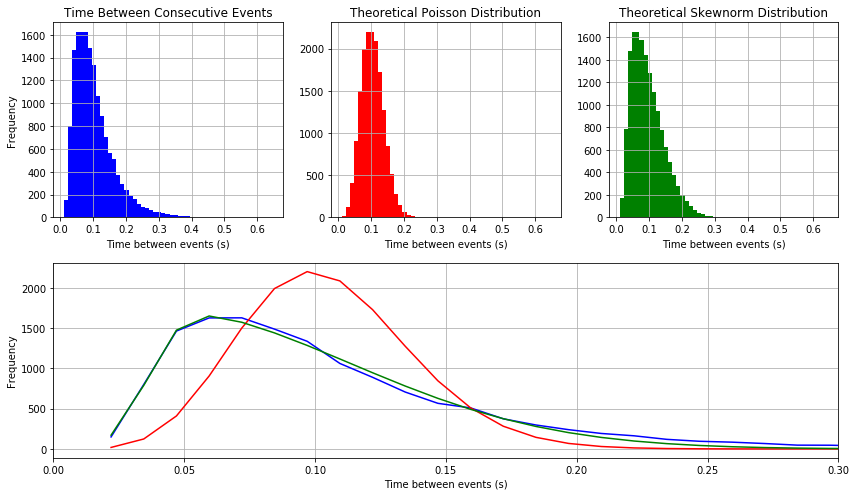

In [25]:
fig = plt.figure(figsize=(12,7))

ax0 = plt.subplot(231)
ax1 = plt.subplot(232)
ax2 = plt.subplot(233)
ax3 = plt.subplot(212)

ax0.bar(times_act, freq_act, width=1/(bins-5), color='b')
ax1.bar(times_act, freq_theo_pois, width=1/(bins-5), color='r')
ax2.bar(times_act, freq_theo_skew, width=1/(bins-5), color='g')

ax3.plot(times_act, freq_act, color='b')
ax3.plot(times_act, freq_theo_pois, color='r')
ax3.plot(times_act, freq_theo_skew, color='g')


ax0.set_xlabel('Time between events (s)')
ax1.set_xlabel('Time between events (s)')
ax2.set_xlabel('Time between events (s)')
ax3.set_xlabel('Time between events (s)')

ax0.set_ylabel('Frequency')
ax3.set_ylabel('Frequency')

ax0.set_title('Time Between Consecutive Events')
ax1.set_title('Theoretical Poisson Distribution')
ax2.set_title('Theoretical Skewnorm Distribution')

ax3.set_xlim(0,0.3)

ax0.grid()
ax1.grid()
ax2.grid()
ax3.grid()

fig.tight_layout()
plt.savefig("plots/appendix_part3_div1", bbox_inches='tight', dpi=300)
plt.show()

## Divide by 2

In [26]:
data = df['Div2'].dropna()
num_events = len(data)
bins = 50

In [27]:
freq_act, _ = np.histogram(data, bins=bins)
times_act = np.array([(_[i+1]+_[i])/2 for i in range(len(_)-1)])

### Poisson Fitting

In [28]:
data_int = (data-times_act[0])/(times_act-times_act[0])[1]
times_act_int = (times_act-times_act[0])/(times_act-times_act[0])[1]

freq_theo_pois = (num_events)*poisson(times_act_int, np.mean(data_int)) 

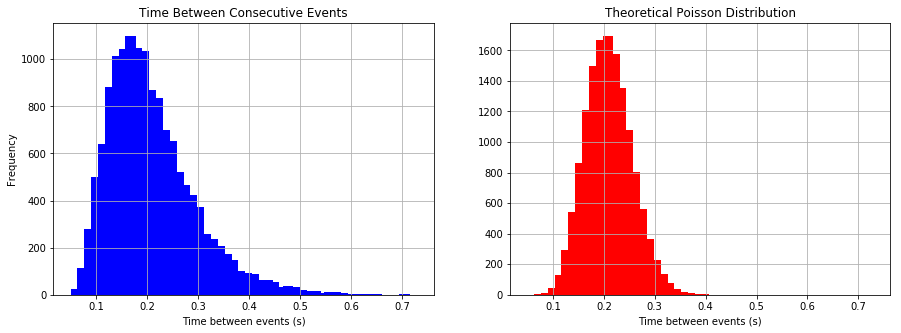

In [29]:
fig, ax = plt.subplots(1,2, figsize=(15,5))


ax[0].bar(times_act, freq_act, width=1/bins, color='b')
ax[1].bar(times_act, freq_theo_pois, width=1/bins, color='r')

ax[0].set_xlabel('Time between events (s)')
ax[1].set_xlabel('Time between events (s)')
ax[0].set_ylabel('Frequency')

ax[0].set_title('Time Between Consecutive Events')
ax[1].set_title('Theoretical Poisson Distribution')

ax[0].grid()
ax[1].grid()

plt.show()

In [30]:
num_bins = len(times_act)
DOF = num_bins - 2

In [31]:
m=np.linspace(0.15, 0.24, 100)
m_int = (m-times_act[0])/(times_act-times_act[0])[1]
chi_test = compute_chi2_pois(m_int, times_act_int, freq_act, num_events)

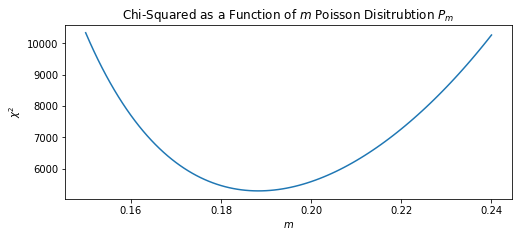

In [32]:
fig, ax = plt.subplots(1,1, figsize=(8,3.2))

ax.plot(m, chi_test)
ax.set_title('Chi-Squared as a Function of $m$ Poisson Disitrubtion $P_m$')
ax.set_xlabel('$m$')
ax.set_ylabel('$\chi^2$')

plt.show()

Print the value of $m$ (the theoretical mean) that minimizes the $\chi^2$ value.

In [33]:
print(m[chi_test.argmin()])

0.18818181818181817


Print the $\chi^2$ value.

In [34]:
print(np.min(chi_test))

5292.279104114976


### Skew-Norm Fitting

In [35]:
popt, pcov = curve_fit(skew_norm, times_act, freq_act, absolute_sigma=True)
freq_theo_skew = skew_norm(times_act, popt[0], popt[1], popt[2], popt[3])

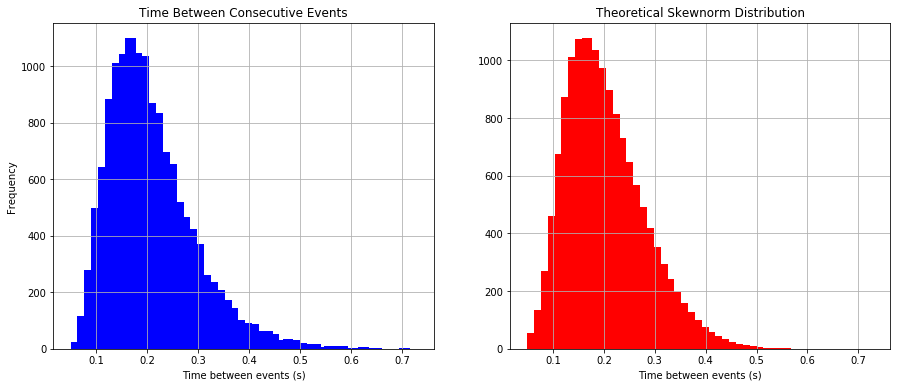

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].bar(times_act, freq_act, width=1/bins, color='b')
ax[1].bar(times_act, freq_theo_skew, width=1/bins, color='r')

ax[0].set_xlabel('Time between events (s)')
ax[1].set_xlabel('Time between events (s)')
ax[0].set_ylabel('Frequency')

ax[0].set_title('Time Between Consecutive Events')
ax[1].set_title('Theoretical Skewnorm Distribution')

ax[0].grid()
ax[1].grid()

plt.show()

In [37]:
chi = compute_chi2(freq_act, freq_theo_skew)
print(chi)

242.9043943194355


### Statistics

In [38]:
data_raw = create_data_array(times_act, freq_act)
data_pois = create_data_array(times_act, freq_theo_pois)
data_skew = create_data_array(times_act, freq_theo_skew)

In [39]:
scale = 1000
print('Poisson Mean '+str(np.average(data_pois)*scale))
print('Skewnorm Mean '+str(np.average(data_skew)*scale))
print('Actual Mean '+str(np.average(data_raw)*scale))
print('')
print('Poisson Std '+str(np.std(data_pois)*scale))
print('Skewnorm Std '+str(np.std(data_skew)*scale))
print('Actual Std '+str(np.std(data_raw)*scale))
print('')
print('Poisson 3mom '+str(sp.stats.moment(data_pois, 3)*scale))
print('Skewnorm 3mom '+str(sp.stats.moment(data_skew, 3)*scale))
print('Actual 3mom '+str(sp.stats.moment(data_raw, 3)*scale))

Poisson Mean 209.5483677199549
Skewnorm Mean 203.71303073744073
Actual Mean 209.56604382439238

Poisson Std 44.81906067638268
Skewnorm Std 76.12447674279825
Actual Std 85.57770513443647

Poisson 3mom 0.02609915026310238
Skewnorm 3mom 0.3428840092916849
Actual 3mom 0.7559887279121412


### Nice Plot for Lab Report

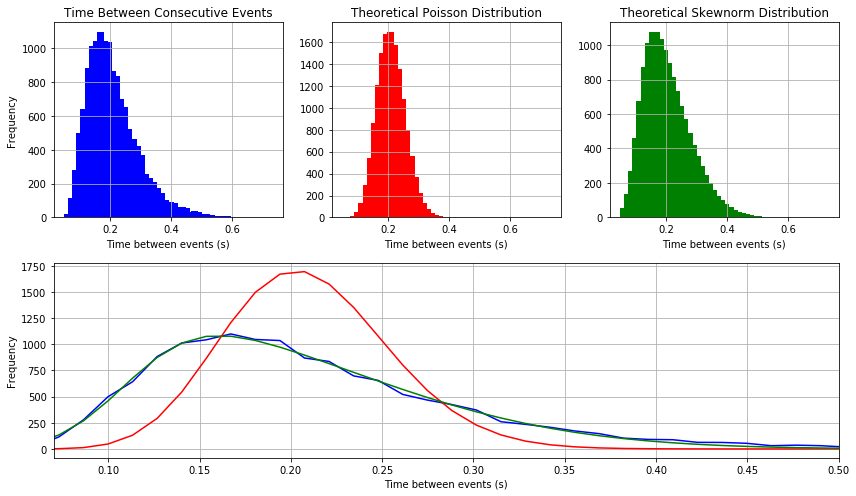

In [40]:
fig = plt.figure(figsize=(12,7))

ax0 = plt.subplot(231)
ax1 = plt.subplot(232)
ax2 = plt.subplot(233)
ax3 = plt.subplot(212)

ax0.bar(times_act, freq_act, width=1/(bins-5), color='b')
ax1.bar(times_act, freq_theo_pois, width=1/(bins-5), color='r')
ax2.bar(times_act, freq_theo_skew, width=1/(bins-5), color='g')

ax3.plot(times_act, freq_act, color='b')
ax3.plot(times_act, freq_theo_pois, color='r')
ax3.plot(times_act, freq_theo_skew, color='g')


ax0.set_xlabel('Time between events (s)')
ax1.set_xlabel('Time between events (s)')
ax2.set_xlabel('Time between events (s)')
ax3.set_xlabel('Time between events (s)')

ax0.set_ylabel('Frequency')
ax3.set_ylabel('Frequency')

ax0.set_title('Time Between Consecutive Events')
ax1.set_title('Theoretical Poisson Distribution')
ax2.set_title('Theoretical Skewnorm Distribution')

ax3.set_xlim(0.07,0.5)

ax0.grid()
ax1.grid()
ax2.grid()
ax3.grid()

fig.tight_layout()
plt.savefig("plots/appendix_part3_div2", bbox_inches='tight', dpi=300)
plt.show()

## Divide by 4

In [41]:
data = df['Div4'].dropna()
num_events = len(data)
bins = 50

In [42]:
freq_act, _ = np.histogram(data, bins=bins)
times_act = np.array([(_[i+1]+_[i])/2 for i in range(len(_)-1)])

In [43]:
times_act

array([0.15407255, 0.17612876, 0.19818496, 0.22024117, 0.24229737,
       0.26435357, 0.28640978, 0.30846598, 0.33052219, 0.35257839,
       0.37463459, 0.3966908 , 0.418747  , 0.44080321, 0.46285941,
       0.48491561, 0.50697182, 0.52902802, 0.55108423, 0.57314043,
       0.59519663, 0.61725284, 0.63930904, 0.66136525, 0.68342145,
       0.70547765, 0.72753386, 0.74959006, 0.77164627, 0.79370247,
       0.81575867, 0.83781488, 0.85987108, 0.88192729, 0.90398349,
       0.92603969, 0.9480959 , 0.9701521 , 0.99220831, 1.01426451,
       1.03632071, 1.05837692, 1.08043312, 1.10248933, 1.12454553,
       1.14660173, 1.16865794, 1.19071414, 1.21277035, 1.23482655])

### Poisson Fitting

In [44]:
data_int = (data-times_act[0])/(times_act-times_act[0])[1]
times_act_int = (times_act-times_act[0])/(times_act-times_act[0])[1]

freq_theo_pois = (num_events)*poisson(times_act_int, np.mean(data_int)) 

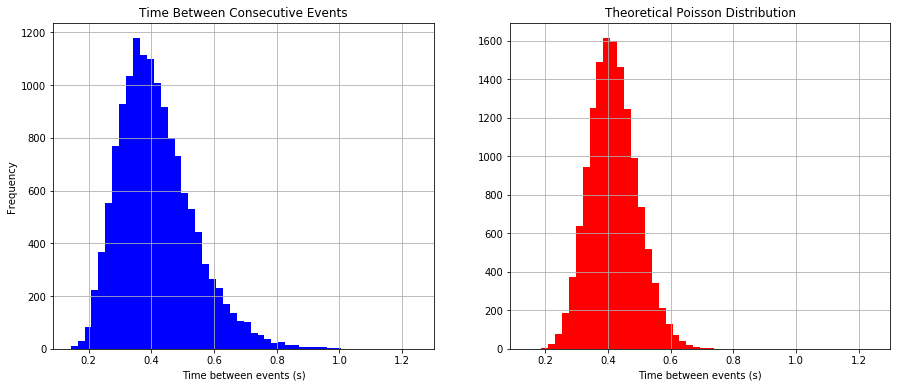

In [45]:
fig, ax = plt.subplots(1,2, figsize=(15,6))


ax[0].bar(times_act, freq_act, width=1/(bins-5), color='b')
ax[1].bar(times_act, freq_theo_pois, width=1/(bins-5), color='r')

ax[0].set_xlabel('Time between events (s)')
ax[1].set_xlabel('Time between events (s)')
ax[0].set_ylabel('Frequency')

ax[0].set_title('Time Between Consecutive Events')
ax[1].set_title('Theoretical Poisson Distribution')

ax[0].grid()
ax[1].grid()

plt.show()

In [46]:
num_bins = len(times_act)
DOF = num_bins - 2

In [47]:
m=np.linspace(0.3, 0.5, 100)
m_int = (m-times_act[0])/(times_act-times_act[0])[1]
chi_test = compute_chi2_pois(m_int, times_act_int, freq_act, num_events)

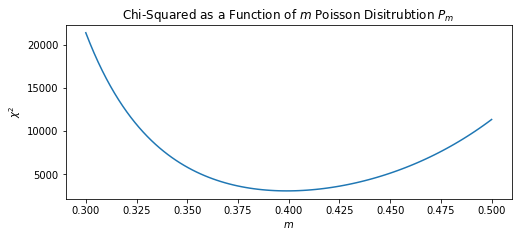

In [48]:
fig, ax = plt.subplots(1,1, figsize=(8,3.2))

ax.plot(m, chi_test)
ax.set_title('Chi-Squared as a Function of $m$ Poisson Disitrubtion $P_m$')
ax.set_xlabel('$m$')
ax.set_ylabel('$\chi^2$')

plt.show()

Print the value of $m$ (the theoretical mean) that minimizes the $\chi^2$ value.

In [49]:
print(m[chi_test.argmin()])

0.398989898989899


Print the $\chi^2$ value.

In [50]:
print(np.min(chi_test))

3086.5010089949665


In [51]:
print(np.min(chi_test)/(DOF))

64.3021043540618


### Skew-Norm Fitting

In [52]:
popt, pcov = curve_fit(skew_norm, times_act, freq_act, absolute_sigma=True)
freq_theo_skew = skew_norm(times_act, popt[0], popt[1], popt[2], popt[3])

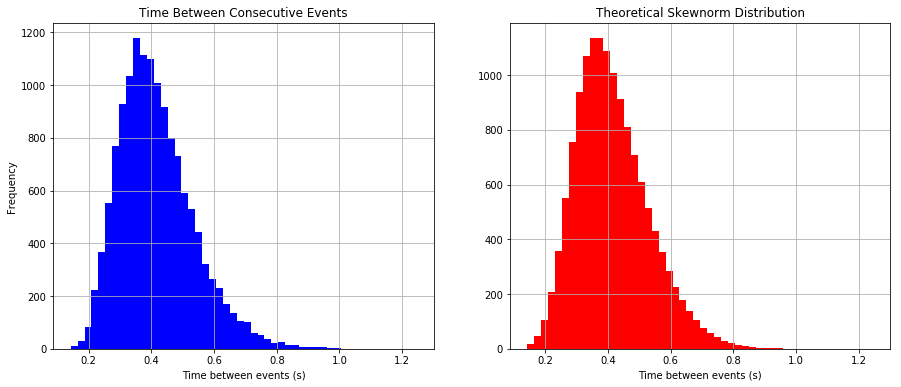

In [53]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].bar(times_act, freq_act, width=1/(bins-5), color='b')
ax[1].bar(times_act, freq_theo_skew, width=1/(bins-5), color='r')

ax[0].set_xlabel('Time between events (s)')
ax[1].set_xlabel('Time between events (s)')
ax[0].set_ylabel('Frequency')

ax[0].set_title('Time Between Consecutive Events')
ax[1].set_title('Theoretical Skewnorm Distribution')

ax[0].grid()
ax[1].grid()

plt.show()

In [54]:
chi = compute_chi2(freq_act, freq_theo_skew)
print(chi)

73.30408377466094


### Statistics

In [55]:
data_raw = create_data_array(times_act, freq_act)
data_pois = create_data_array(times_act, freq_theo_pois)
data_skew = create_data_array(times_act, freq_theo_skew)

In [56]:
scale = 1000
print('Poisson Mean '+str(np.average(data_pois)*scale))
print('Skewnorm Mean '+str(np.average(data_skew)*scale))
print('Actual Mean '+str(np.average(data_raw)*scale))
print('')
print('Poisson Std '+str(np.std(data_pois)*scale))
print('Skewnorm Std '+str(np.std(data_skew)*scale))
print('Actual Std '+str(np.std(data_raw)*scale))
print('')
print('Poisson 3mom '+str(sp.stats.moment(data_pois, 3)*scale))
print('Skewnorm 3mom '+str(sp.stats.moment(data_skew, 3)*scale))
print('Actual 3mom '+str(sp.stats.moment(data_raw, 3)*scale))

Poisson Mean 416.64122841905066
Skewnorm Mean 413.70458914290447
Actual Mean 416.7013462347741

Poisson Std 75.93070899600245
Skewnorm Std 115.17944996301095
Actual Std 119.3506509200198

Poisson 3mom 0.12243365735389625
Skewnorm 3mom 0.9955086299128975
Actual 3mom 1.4520558357808575


### Nice Plot for Lab Report

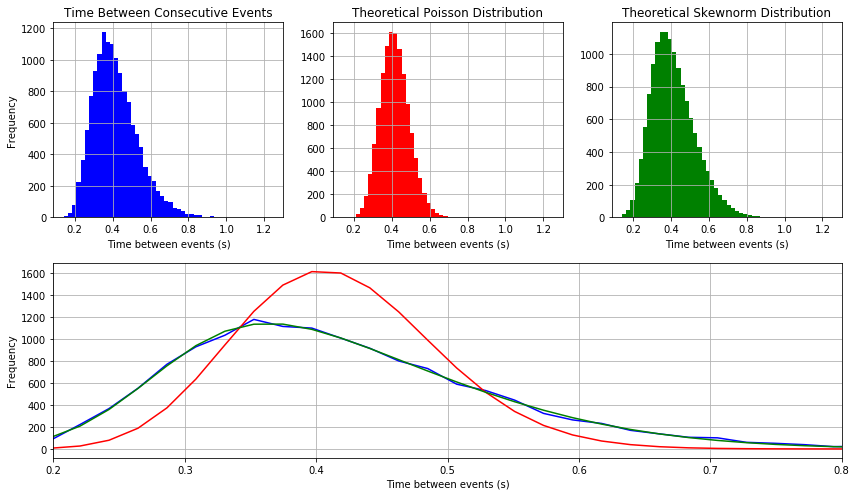

In [57]:
fig = plt.figure(figsize=(12,7))

ax0 = plt.subplot(231)
ax1 = plt.subplot(232)
ax2 = plt.subplot(233)
ax3 = plt.subplot(212)

ax0.bar(times_act, freq_act, width=1/(bins-5), color='b')
ax1.bar(times_act, freq_theo_pois, width=1/(bins-5), color='r')
ax2.bar(times_act, freq_theo_skew, width=1/(bins-5), color='g')

ax3.plot(times_act, freq_act, color='b')
ax3.plot(times_act, freq_theo_pois, color='r')
ax3.plot(times_act, freq_theo_skew, color='g')


ax0.set_xlabel('Time between events (s)')
ax1.set_xlabel('Time between events (s)')
ax2.set_xlabel('Time between events (s)')
ax3.set_xlabel('Time between events (s)')

ax0.set_ylabel('Frequency')
ax3.set_ylabel('Frequency')

ax0.set_title('Time Between Consecutive Events')
ax1.set_title('Theoretical Poisson Distribution')
ax2.set_title('Theoretical Skewnorm Distribution')

ax3.set_xlim(0.2,0.8)

ax0.grid()
ax1.grid()
ax2.grid()
ax3.grid()

fig.tight_layout()
plt.savefig("plots/appendix_part3_div4", bbox_inches='tight', dpi=300)
plt.show()